## Лабораторная №1

## Учимся распознавать ирисы

Мы используем знаменитый в области Data Science набор данных, содержащий измерения 4 параметров длины цветка для трех разных типов ирисов.

In [1]:
%matplotlib inline
import cntk
from cntk import Trainer
from cntk.learners import sgd
from cntk.ops import *
from cntk.io import *
from cntk.layers import *
import pylab

In [2]:
from IPython.display import IFrame
IFrame('https://en.wikipedia.org/wiki/Iris_flower_data_set', width=800, height=350)

Для чтения данных в формате `CSV` используем библиотеку `pandas`. Объекты, с которыми оперирует `pandas`, называются *data frames*

In [3]:
import pandas as pd

iris = pd.read_csv('https://raw.githubusercontent.com/mwaskom/seaborn-data/master/iris.csv')
iris

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
5,5.4,3.9,1.7,0.4,setosa
6,4.6,3.4,1.4,0.3,setosa
7,5.0,3.4,1.5,0.2,setosa
8,4.4,2.9,1.4,0.2,setosa
9,4.9,3.1,1.5,0.1,setosa


Мы можем посмотреть на то, как коррелируют друг с другом те или иные признаки:

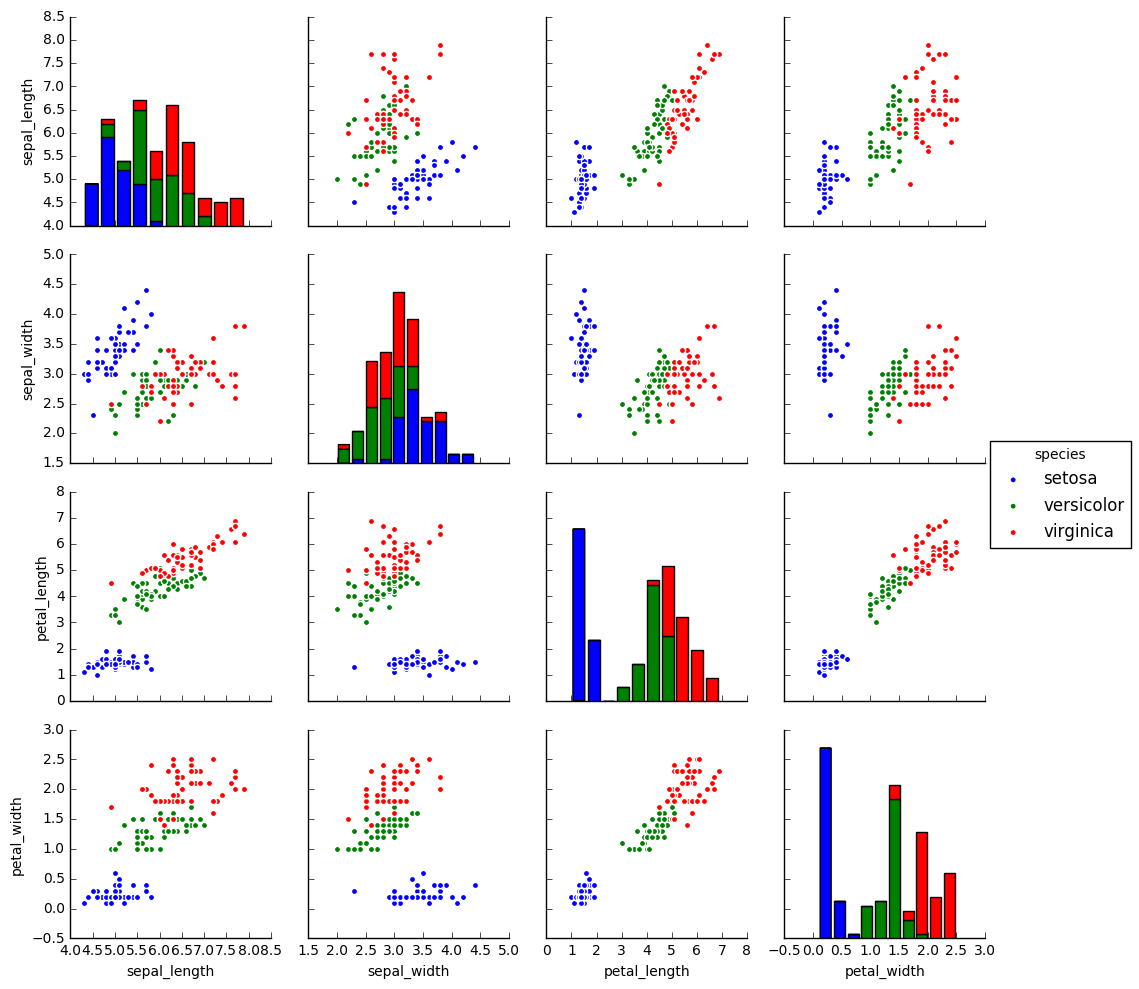

In [4]:
import seaborn.apionly as sns
pp = sns.pairplot(iris, hue="species")

## CNTK

Для обучение сети будем использовать `CNTK`. CNTK умеет получать входные данные из разных источников:

 * Из объектов `numpy array`
 * Из внешних текстовых файлов
    - текстовые данные представляются в специальном формате
    - картинки описываются map-файлом и множеством файлов с изображениеми на диске
    
Преобразуем наш набор данных к текстовому виду, пригодному для CNTK

In [5]:
# Строим отображение типов ирисов на номер класса
fwmap = dict(enumerate(set(iris.values[:,4])))
bkmap = {fwmap[k] : k for k in fwmap}
print(fwmap,bkmap)

{0: 'setosa', 1: 'virginica', 2: 'versicolor'} {'setosa': 0, 'virginica': 1, 'versicolor': 2}


In [7]:
def conv(n):
    """
    Преобразует название класса в трехмерный вектор из нулей и единиц
    """
    return [ 1 if x==n else 0 for i,x in fwmap.items() ]

def dump(seq,fname):
    with open(fname,'w') as f:
        for x in seq:
            f.write("|label {}|features {} {} {} {}\n".format(" ".join(map(str,conv(x[4]))),x[0],x[1],x[2],x[3]))

data = np.random.permutation(iris.values)
dump(data[0:130],'iris_train.txt')
dump(data[130:],'iris_test.txt')
!cat iris_test.txt

|label 1 0 0|features 5.2 3.4 1.4 0.2
|label 0 0 1|features 5.6 2.7 4.2 1.3
|label 0 0 1|features 4.9 2.4 3.3 1.0
|label 1 0 0|features 5.4 3.9 1.7 0.4
|label 1 0 0|features 5.0 3.5 1.3 0.3
|label 0 0 1|features 6.0 2.2 4.0 1.0
|label 0 0 1|features 6.3 3.3 4.7 1.6
|label 1 0 0|features 5.1 3.5 1.4 0.3
|label 0 0 1|features 5.7 2.8 4.1 1.3
|label 1 0 0|features 5.2 3.5 1.5 0.2
|label 0 0 1|features 6.2 2.9 4.3 1.3
|label 0 1 0|features 6.8 3.2 5.9 2.3
|label 0 1 0|features 7.7 2.8 6.7 2.0
|label 1 0 0|features 4.8 3.4 1.6 0.2
|label 0 1 0|features 7.2 3.6 6.1 2.5
|label 0 1 0|features 7.7 3.8 6.7 2.2
|label 0 0 1|features 5.6 3.0 4.1 1.3
|label 0 0 1|features 7.0 3.2 4.7 1.4
|label 0 1 0|features 6.4 2.8 5.6 2.2
|label 0 0 1|features 5.7 2.6 3.5 1.0


## Reader = Minibatch Source + Deserializer

Для чтения данных используется MinibatchSource, который умеет:

 * Преобразовывать данные из текстового формата на лету с помощью `Deserializer`
    - по умолчанию доступны десериализаторы `CTFDeserializer` для текстового формата CNTK, `ImageDeserializer` для картинок и ещё один для последовательностей
 * Перебирать данные по нескольку раз
    - зацикливаться или заканчиваться
 * Автоматически обеспечивают рандомизацию данных

In [8]:
reader_train = MinibatchSource(CTFDeserializer('iris_train.txt',
         StreamDefs(
           labels   = StreamDef(field='label',shape=3),
           features = StreamDef(field='features',shape=4))))

reader_test = MinibatchSource(CTFDeserializer('iris_test.txt',
         StreamDefs(
           labels   = StreamDef(field='label',shape=3),
           features = StreamDef(field='features',shape=4))))

Описываем переменные, модель и ошибку

In [9]:
input_var = input_variable(4)
label_var = input_variable(3)

model = Dense(3, init=glorot_uniform(),activation=None);

# Подсказка: попробуйте использовать model = Sequential([....]) для комбинации слоёв!

z = model(input_var)

ce = cntk.cross_entropy_with_softmax(z, label_var)
pe = cntk.classification_error(z, label_var)


Описываем `learner` и `trainer`. Переменная `progress` будет хранить достигнутую точность на разных шагах обучения.

In [10]:
minibatch_size = 16

lr_per_minibatch = cntk.learning_rate_schedule(0.01, cntk.UnitType.minibatch)
pp = cntk.logging.ProgressPrinter()
    
learner = cntk.adagrad(z.parameters, lr = lr_per_minibatch)
trainer = cntk.Trainer(z, (ce, pe), [learner],[pp])

input_map = {
    input_var: reader_train.streams.features,
    label_var: reader_train.streams.labels
}

cntk.logging.log_number_of_parameters(z)
progress = []

Training 15 parameters in 2 parameter tensors.


Начинаем обучение. Обратите внимание, что вы можете менять количество эпох и минибатчей в каждой эпохе. Можете запускать этот блок несколько раз, он будет дообучать модель и достраивать график.

Learning rate per minibatch: 0.01
Finished Epoch[1 of 300]: loss = 1.273110 * 8000, metric = 41.66% * 8000 2.234s (3581.3 samples/s);
Finished Epoch[2 of 300]: loss = 0.440873 * 8000, metric = 13.44% * 8000 0.578s (13837.0 samples/s);
Finished Epoch[3 of 300]: loss = 0.367969 * 8000, metric = 5.94% * 8000 0.563s (14221.4 samples/s);
Finished Epoch[4 of 300]: loss = 0.323731 * 8000, metric = 4.54% * 8000 0.547s (14627.7 samples/s);
Finished Epoch[5 of 300]: loss = 0.292336 * 8000, metric = 4.51% * 8000 0.625s (12799.2 samples/s);
Finished Epoch[6 of 300]: loss = 0.268508 * 8000, metric = 4.91% * 8000 0.531s (15058.0 samples/s);
Finished Epoch[7 of 300]: loss = 0.249438 * 8000, metric = 4.95% * 8000 0.578s (13837.1 samples/s);
Finished Epoch[8 of 300]: loss = 0.234228 * 8000, metric = 5.12% * 8000 0.563s (14221.4 samples/s);
Finished Epoch[9 of 300]: loss = 0.221420 * 8000, metric = 5.15% * 8000 0.594s (13472.9 samples/s);
Finished Epoch[10 of 300]: loss = 0.210433 * 8000, metric = 5.08%

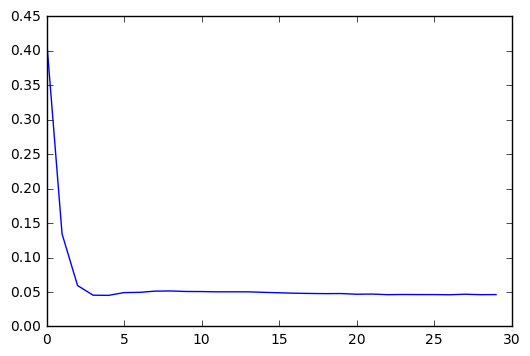

In [11]:

for x in range(30):
    tloss = 0; taccuracy = 0; cnt = 0;
    for y in range(500):
        data = reader_train.next_minibatch(minibatch_size,input_map)
        t = trainer.train_minibatch(data)
        tloss += trainer.previous_minibatch_loss_average*trainer.previous_minibatch_sample_count
        taccuracy += trainer.previous_minibatch_evaluation_average*trainer.previous_minibatch_sample_count
        cnt+=trainer.previous_minibatch_sample_count
        pp.update_with_trainer(trainer,with_metric=True)
    progress.append([float(x),tloss/cnt,taccuracy/cnt])
    pp.epoch_summary(with_metric=True)

progress = np.array(progress)
pylab.plot(progress[:,0],progress[:,2])


In [12]:
test_size = 20

data = reader_test.next_minibatch(test_size, input_map=input_map)
metric = trainer.test_minibatch(data)

print("Eval error = {}".format(metric))

Eval error = 0.0


## Задание

1. Попробовать достичь минимальной величины ошибки на тестовых данных за счет изменения архитектуры сети
   - попробуйте многослойный персептрон
   - попробуйте разные функции активации
2. В процессе обучения строить training error и testing error и посмотреть, если ли переобучение